In [1]:
import pandas as pd

# Listing all 7 files below 
files = [
    'synthetic_stemi_llama3_llm_sixth_batch.csv',
    'synthetic_stemi_llama3_llm_eighth_batch.csv',
    'synthetic_stemi_llama3_llm_fifth_batch.csv',
    'synthetic_stemi_llama3_llm_fourth_batch.csv',
    'synthetic_stemi_llama3_llm_second_batch.csv',
    'synthetic_stemi_llama3_llm_seventh_batch.csv',
    'synthetic_stemi_llama3_llm_third_batch.csv'
]

#Combining all files and saving to a single file
df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
df.to_csv('synthetic_data_combined.csv', index=False)

print("Combined file saved as 'synthetic_data_combined.csv'")


Combined file saved as 'synthetic_data_combined.csv'


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, ttest_ind, mannwhitneyu, chi2_contingency, f_oneway, pearsonr
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
import plotly.express as px
import plotly.graph_objects as go


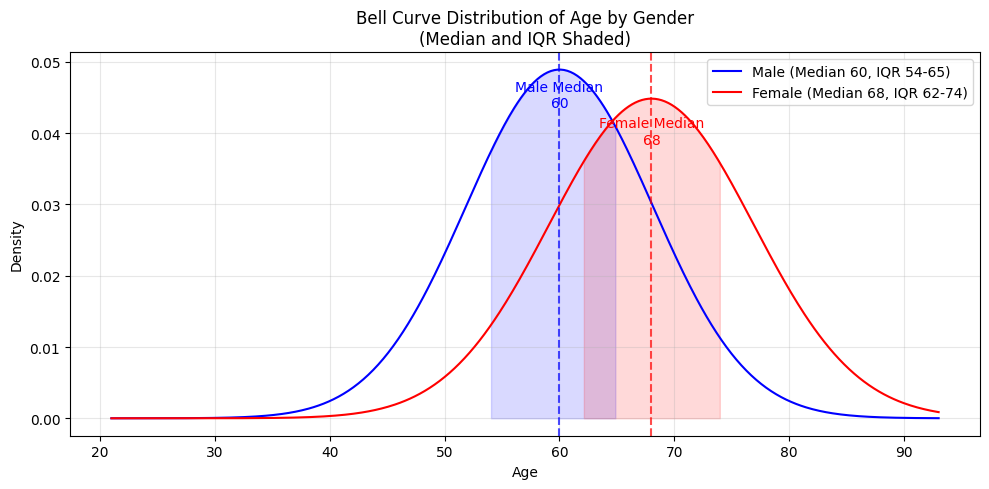

In [4]:
# Compute median & IQR for age per sex
def get_stats(df, sex_value):
    ages = df[df['sex'] == sex_value]['age'].dropna()
    med = np.median(ages)
    q1 = np.percentile(ages, 25)
    q3 = np.percentile(ages, 75)
    iqr = q3 - q1
    std = iqr / 1.349 if iqr > 0 else 1
    return med, std, q1, q3

# Compute stats
med_m, std_m, q1_m, q3_m = get_stats(df, 'male')
med_f, std_f, q1_f, q3_f = get_stats(df, 'female')

# Define age range for plotting
age_min = int(min(df['age'].min(), 40))
age_max = int(max(df['age'].max(), 90))
x = np.linspace(age_min, age_max, 500)

# Bell curves
y_m = norm.pdf(x, med_m, std_m)
y_f = norm.pdf(x, med_f, std_f)

plt.figure(figsize=(10,5))
plt.plot(x, y_m, label=f"Male (Median {med_m:.0f}, IQR {q1_m:.0f}-{q3_m:.0f})", color='blue')
plt.plot(x, y_f, label=f"Female (Median {med_f:.0f}, IQR {q1_f:.0f}-{q3_f:.0f})", color='red')

# Shade IQR regions
plt.fill_between(x, 0, y_m, where=(x>=q1_m)&(x<=q3_m), color='blue', alpha=0.15)
plt.fill_between(x, 0, y_f, where=(x>=q1_f)&(x<=q3_f), color='red', alpha=0.15)

# Annotate medians
plt.axvline(med_m, color='blue', linestyle='--', alpha=0.7)
plt.axvline(med_f, color='red', linestyle='--', alpha=0.7)
plt.text(med_m, plt.ylim()[1]*0.85, f"Male Median\n{med_m:.0f}", color='blue', ha='center')
plt.text(med_f, plt.ylim()[1]*0.75, f"Female Median\n{med_f:.0f}", color='red', ha='center')

plt.title("Bell Curve Distribution of Age by Gender\n(Median and IQR Shaded)")
plt.xlabel("Age")
plt.ylabel("Density")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


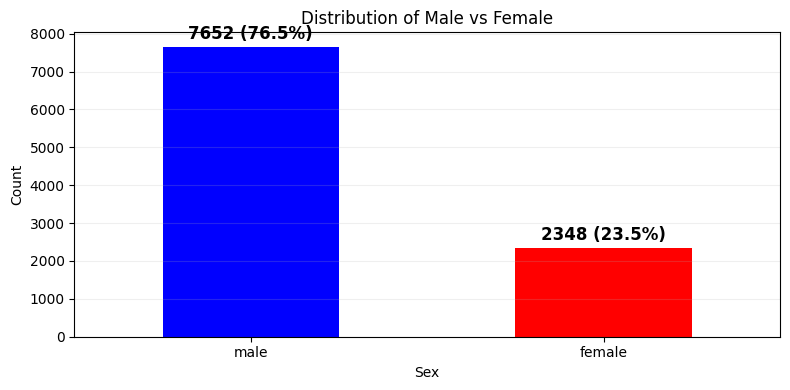

In [5]:
# Count and percentage
gender_counts = df['sex'].value_counts()
total = gender_counts.sum()
percentages = (gender_counts / total * 100).round(1)

plt.figure(figsize=(8,4))
ax = gender_counts.plot(kind='bar', color=['blue', 'red'])

for i, (count, pct) in enumerate(zip(gender_counts, percentages)):
    ax.text(i, count + total*0.01, f"{count} ({pct}%)", 
            ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Distribution of Male vs Female')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.2)
plt.tight_layout()
plt.show()


Male ≥65 years: 2392 / 7652 = 31.3%
Female ≥65 years: 1557 / 2348 = 66.3%


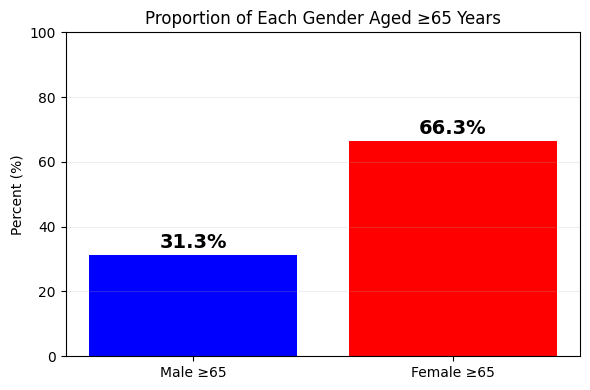

In [6]:
# Getting the total counts for sex
male_total = df[df['sex'] == 'male']
female_total = df[df['sex'] == 'female']

# Calculating the number aged greater than and equal to 65
male_65 = male_total[male_total['age'] >= 65]
female_65 = female_total[female_total['age'] >= 65]

# Calculating percentages
male_pct = 100 * len(male_65) / max(len(male_total), 1)
female_pct = 100 * len(female_65) / max(len(female_total), 1)

print(f"Male ≥65 years: {len(male_65)} / {len(male_total)} = {male_pct:.1f}%")
print(f"Female ≥65 years: {len(female_65)} / {len(female_total)} = {female_pct:.1f}%")

# Plots 
plt.figure(figsize=(6,4))
bars = plt.bar(['Male ≥65', 'Female ≥65'], [male_pct, female_pct], color=['blue', 'red'])

for bar, pct in zip(bars, [male_pct, female_pct]):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f"{pct:.1f}%", 
             ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.title('Proportion of Each Gender Aged ≥65 Years')
plt.ylabel('Percent (%)')
plt.ylim(0, 100)
plt.grid(axis='y', alpha=0.2)
plt.tight_layout()
plt.show()



Age group dist:
19–40: 2.9%
41–64: 51.5%
65–79: 34.7%
≥80: 10.9%


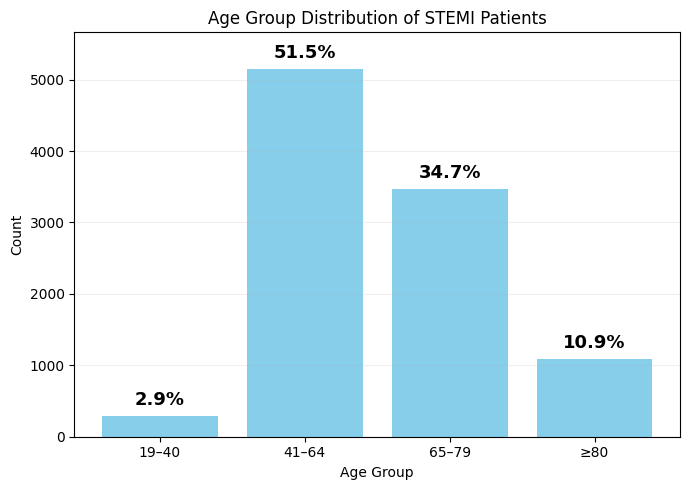

In [7]:
if age_group_col:
    group_counts = df[age_group_col].value_counts().reindex(["19–40", "41–64", "65–79", "≥80"], fill_value=0)
    total = group_counts.sum()
    percentages = (group_counts / total * 100).round(1)
    print("\nAge group dist:")
    for g, pct in percentages.items():
        print(f"{g}: {pct:.1f}%")
    
    # BAR CHART WITH PERCENTAGES
    fig, ax = plt.subplots(figsize=(7,5))
    bars = ax.bar(group_counts.index, group_counts.values, color='skyblue')
    for bar, pct in zip(bars, percentages):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + total*0.01, f"{pct}%", 
                ha='center', va='bottom', fontsize=13, fontweight='bold')
    plt.title('Age Group Distribution of STEMI Patients')
    plt.xlabel('Age Group')
    plt.ylabel('Count')
    plt.ylim(0, group_counts.max()*1.1)
    plt.grid(axis='y', alpha=0.2)
    plt.tight_layout()
    plt.show()
else:
    print("No 'age_group' column found. Please check column names.")

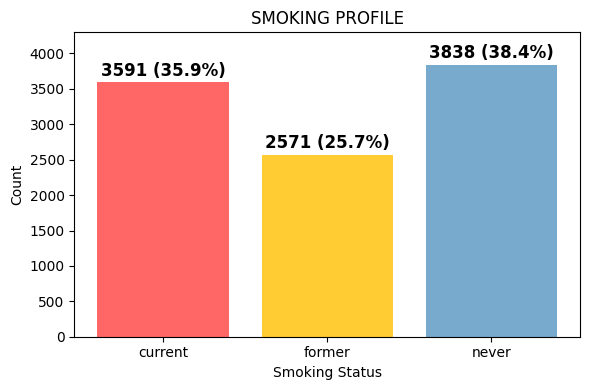

In [8]:
# Bar Chart for Smoking Status Distribution
if smoking_col:
    smoking_vals = df[smoking_col].astype(str)
    counts = smoking_vals.value_counts()
    percentages = (counts / counts.sum() * 100).round(1)
    cats = ['current', 'former', 'never']
    bar_heights = [counts.get(c,0) for c in cats]
    bar_pcts = [percentages.get(c,0) for c in cats]

    plt.figure(figsize=(6,4))
    bars = plt.bar(cats, bar_heights, color=['#f66', '#fc3', '#7ac'])

    for i, (bar, pct) in enumerate(zip(bars, bar_pcts)):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(bar_heights)*0.01, 
                 f"{bar_heights[i]} ({pct}%)", ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.title("SMOKING PROFILE")
    plt.xlabel("Smoking Status")
    plt.ylabel("Count")
    plt.ylim(0, max(bar_heights)*1.12)
    plt.tight_layout()
    plt.show()
else:
    print("Smoking status column not found")

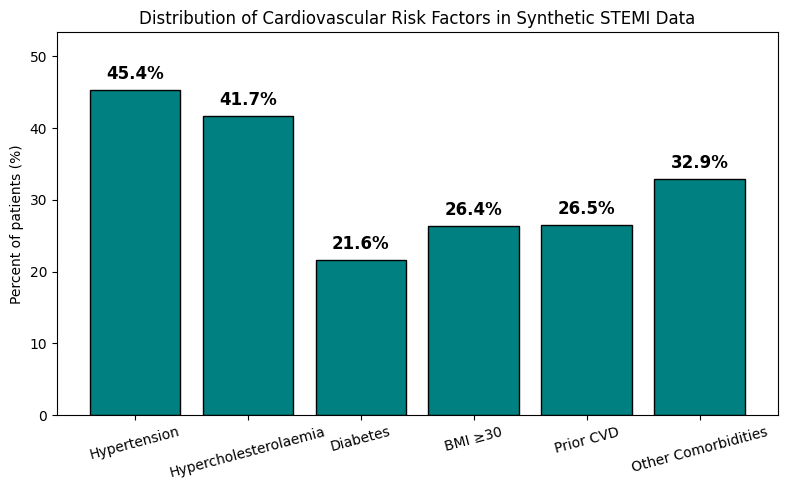

In [9]:
risk_labels = [
    "Hypertension", "Hypercholesterolaemia", "Diabetes",
    "BMI ≥30", "Prior CVD", "Other Comorbidities"
]
risk_cols = [hypertension_col, chol_col, diab_col, bmi_col, priorcvd_col, comorb_col]
risk_pcts = [
    100 * df[col].astype(str).str.lower().isin(['true', '1']).mean() if col else 0
    for col in risk_cols
]

# Bar plot
plt.figure(figsize=(8, 5))
bars = plt.bar(risk_labels, risk_pcts, color="teal", edgecolor="k")

for i, pct in enumerate(risk_pcts):
    plt.text(i, pct + 1, f"{pct:.1f}%", ha="center", va="bottom", fontsize=12, fontweight="bold")

plt.ylim(0, max(risk_pcts) + 8)
plt.ylabel("Percent of patients (%)")
plt.title("Distribution of Cardiovascular Risk Factors in Synthetic STEMI Data")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

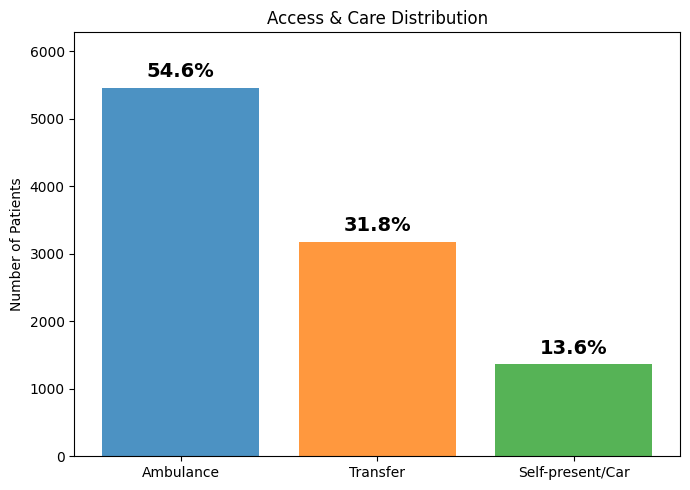

In [10]:
if mode_col:
    vals = df[mode_col].astype(str)
    # Having count and order for the three categories
    labels = ['Ambulance', 'Transfer', 'Self-present/Car']
    keys = ['ambulance', 'transfer', 'private_vehicle']
    counts = [vals.value_counts().get(k,0) for k in keys]
    percentages = [100*c/len(df) for c in counts]

    # Ploting
    fig, ax = plt.subplots(figsize=(7,5))
    bars = ax.bar(labels, counts, color=['#1f77b4','#ff7f0e','#2ca02c'], alpha=0.8)

    # Add percentage labels on top
    for i, (b, pct) in enumerate(zip(bars, percentages)):
        ax.text(b.get_x() + b.get_width()/2, b.get_height()+len(df)*0.01,
                f"{pct:.1f}%", ha='center', va='bottom', fontsize=14, fontweight='bold')

    ax.set_title('Access & Care Distribution')
    ax.set_ylabel('Number of Patients')
    plt.ylim(0, max(counts)*1.15)
    plt.tight_layout()
    plt.show()
else:
    print("Mode of arrival column not found!")



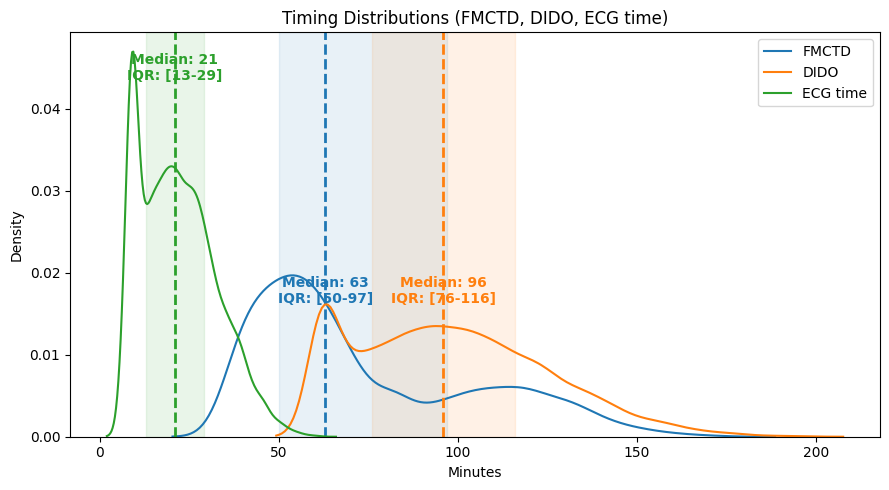

In [11]:
timing_data = {}
for col, label in zip([fmctd_col, dido_col, ecg_col], ['FMCTD', 'DIDO', 'ECG time']):
    if col:
        vals = df[col].dropna().values
        if len(vals):
            vals = np.array(vals)
            med = np.median(vals)
            q25, q75 = np.percentile(vals, 25), np.percentile(vals, 75)
            timing_data[label] = dict(
                values=vals,
                median=med,
                iqr_low=q25,
                iqr_high=q75
            )

# Plotting bell curves with median/IQR annotations
plt.figure(figsize=(9,5))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
for idx, (label, stats) in enumerate(timing_data.items()):
    vals = stats['values']
    # Plot the bell curve
    try:
        import seaborn as sns
        sns.kdeplot(vals, label=label, color=colors[idx])
    except ImportError:
        plt.hist(vals, bins=50, alpha=0.4, label=label, color=colors[idx], density=True)
    # Plotting median line
    plt.axvline(stats['median'], color=colors[idx], linestyle='--', lw=2)
    # Plotting IQR
    plt.axvspan(stats['iqr_low'], stats['iqr_high'], color=colors[idx], alpha=0.1)

    # Annotattion
    plt.text(stats['median'], plt.ylim()[1]*0.95, 
             f"Median: {stats['median']:.0f}\nIQR: [{stats['iqr_low']:.0f}-{stats['iqr_high']:.0f}]", 
             color=colors[idx], ha='center', va='top', fontsize=10, fontweight='bold')

plt.title("Timing Distributions (FMCTD, DIDO, ECG time)")
plt.xlabel("Minutes")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

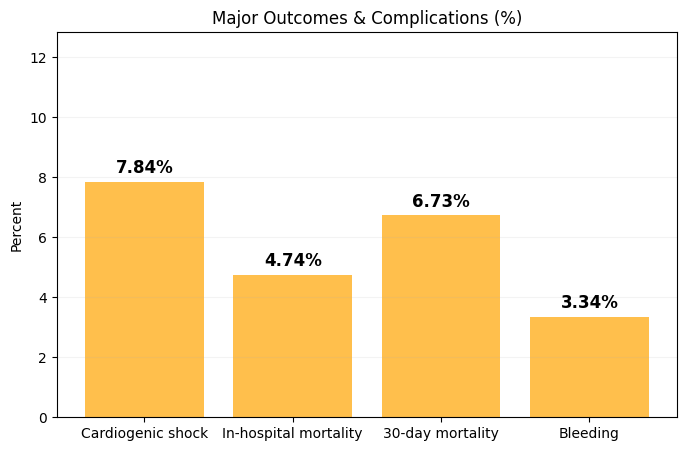

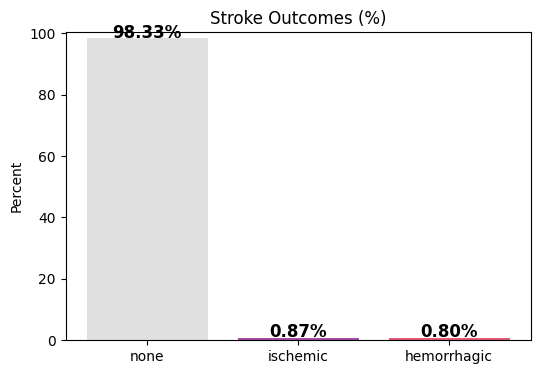

In [12]:
# For Cardiogenic Shock, In-Hospital Mortality, 30-Day Mortality, Bleeding 
fields = [
    ('shock', 'Cardiogenic shock'),
    ('in_hospital_mort', 'In-hospital mortality'),
    ('day_30', '30-day mortality'),
    ('bleed', 'Bleeding')
]
results = []
labels = []
for k, lbl in fields:
    col = find_col([k])
    if col:
        val = 100 * df[col].astype(str).str.lower().isin(['true','1']).mean()
        results.append(val)
        labels.append(lbl)
if results:
    plt.figure(figsize=(8,5))
    ax = plt.bar(labels, results, color='orange', alpha=0.7)
    for i, v in enumerate(results):
        plt.text(i, v + 0.3, f"{v:.2f}%", ha='center', fontsize=12, fontweight='bold')
    plt.title('Major Outcomes & Complications (%)')
    plt.ylabel('Percent')
    plt.ylim(0, max(results)+5)
    plt.grid(axis='y', alpha=0.15)
    plt.show()

# Stroke
stroke_col = find_col(['stroke'])
if stroke_col:
    s = df[stroke_col].astype(str)
    cats = ["none", "ischemic", "hemorrhagic"]
    vals = [100*s.value_counts(normalize=True).get(cat,0) for cat in cats]
    fig, ax = plt.subplots(figsize=(6,4))
    ax.bar(cats, vals, color=['lightgrey', 'purple', 'crimson'], alpha=0.7)
    for i, v in enumerate(vals):
        ax.text(i, v+0.2, f"{v:.2f}%", ha='center', fontsize=12, fontweight='bold')
    ax.set_title('Stroke Outcomes (%)')
    ax.set_ylabel('Percent')
    ax.set_ylim(0, max(vals)+2)
    plt.show()

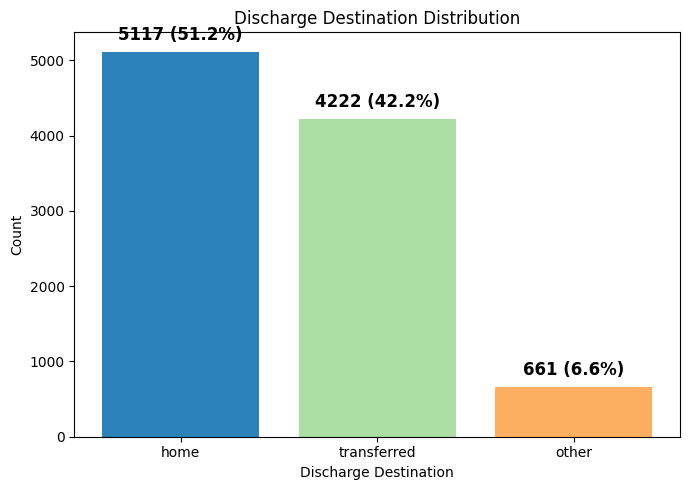

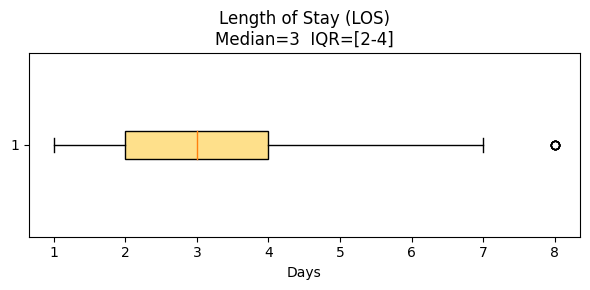


==== LOCATION, LOS, DISCHARGE ====
LOS: median 3 [IQR 2-4]
Discharged to home: 51.2%
Discharged to transferred: 42.2%
Discharged to other: 6.6%


In [13]:
# BAR CHART for Discharge Destinations 
plt.figure(figsize=(7,5))
discharge_counts = df[discharge_col].value_counts()
total = discharge_counts.sum()
colors = ['#2b83ba','#abdda4','#fdae61']
bars = plt.bar(discharge_counts.index, discharge_counts, color=colors)

# Adding % labels above bars
for bar, count in zip(bars, discharge_counts):
    pct = 100 * count / total
    plt.text(bar.get_x() + bar.get_width()/2, count + total*0.01, f"{count} ({pct:.1f}%)",
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title("Discharge Destination Distribution")
plt.xlabel("Discharge Destination")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# BOX PLOT for Length of Stay
if los_col:
    plt.figure(figsize=(6,3))
    data = df[los_col].dropna()
    plt.boxplot(data, vert=False, patch_artist=True, boxprops=dict(facecolor='#fee08b'))
    median = np.median(data)
    q25, q75 = np.percentile(data, 25), np.percentile(data, 75)
    plt.title(f"Length of Stay (LOS)\nMedian={median:.0f}  IQR=[{q25:.0f}-{q75:.0f}]")
    plt.xlabel("Days")
    plt.tight_layout()
    plt.show()
else:
    print("LOS column not found!")

# PRINTING VALUES FOR REFERENCE
print("\n==== LOCATION, LOS, DISCHARGE ====")
if los_col:
    vals = df[los_col].dropna()
    if len(vals):
        med = np.median(vals)
        q25, q75 = np.percentile(vals,25), np.percentile(vals,75)
        print(f"LOS: median {med:.0f} [IQR {q25:.0f}-{q75:.0f}]")
if discharge_col:
    d = df[discharge_col].astype(str)
    for v in ['home','transferred','other']:
        print(f"Discharged to {v}: {100*d.value_counts(normalize=True).get(v,0):.1f}%")


# Case 1: Introducing advantage of 10 mins for getting in contact with call center for arranging ambulance, Additionally giving an advantage of 25% for car to speedup when we have this feature available in Car

In [14]:
# Making a fresh copy of the dataset
df_policy = df.copy()

# Improve in call centre response time(Ambulance only): +10 mins
df_policy["fmctd_policy"] = df_policy["fmctd_time_mins"].astype(float)
df_policy.loc[df_policy["mode_of_arrival"] == "ambulance", "fmctd_policy"] -= 10

# Introducing road priority for cars by 25%
df_policy.loc[df_policy["mode_of_arrival"] == "private_vehicle", "fmctd_policy"] *= 0.75

# Hospital-side pickup unit improvement by 8 mins
df_policy["fmctd_policy"] -= 8
df_policy["fmctd_policy"] = df_policy["fmctd_policy"].clip(lower=0)

# Comparing average FMCTD before and after the case 
avg_original_amb = df[df["mode_of_arrival"] == "ambulance"]["fmctd_time_mins"].mean()
avg_original_car = df[df["mode_of_arrival"] == "private_vehicle"]["fmctd_time_mins"].mean()
avg_policy_amb = df_policy[df_policy["mode_of_arrival"] == "ambulance"]["fmctd_policy"].mean()
avg_policy_car = df_policy[df_policy["mode_of_arrival"] == "private_vehicle"]["fmctd_policy"].mean()

# Summary
policy_summary = pd.DataFrame({
    "Metric": [
        "Avg FMCTD (Original) - Ambulance",
        "Avg FMCTD (Original) - Private Vehicle",
        "Avg FMCTD (Policy) - Ambulance",
        "Avg FMCTD (Policy) - Private Vehicle",
    ],
    "Value": [
        round(avg_original_amb, 2),
        round(avg_original_car, 2),
        round(avg_policy_amb, 2),
        round(avg_policy_car, 2),
    ]
})

policy_summary


,Metric,Value
0,Avg FMCTD (Original) - Ambulance,57.65
1,Avg FMCTD (Original) - Private Vehicle,44.85
2,Avg FMCTD (Policy) - Ambulance,39.65
3,Avg FMCTD (Policy) - Private Vehicle,25.64


In general case Ambulance average FMCTD is 57.65 mins while private car takes only 44.85 mins. If we are introducing a delay of 10 mins to ambulance then average FMCTD increases by 2mins while if we increase average speed by 25% then the average FMCTD get reduced to 25.64 mins which is very less compared to the ambulance. Thus given a chance if we get a chance to create a ecosystem where we can facilitate car to take patient to hospital then it can work in patient favour and thus results in giving some free space to ambulance so that they can support another patient in need


# Case 2: We assign same average speed to Car which we have for ambulance, add delay of 10 mins to Ambulance and keep average speed of car to 35km/hr under dense city condition

In [15]:
# Making a fresh copy of the dataset
df_speed = df.copy()

# Case  A - Cars move at speed of 60km/h
df_speed["sim_speed_car_priority"] = 60
df_speed["sim_fmctd_car_priority"] = df_speed["distance_km"] / df_speed["sim_speed_car_priority"] * 60
df_speed.loc[df_speed["mode_of_arrival"] != "private_vehicle", "sim_fmctd_car_priority"] = np.nan

# Case B - Cars stuck in traffic and moves at speed of 35 km/h
df_speed["sim_speed_car_traffic"] = 35
df_speed["sim_fmctd_car_traffic"] = df_speed["distance_km"] / df_speed["sim_speed_car_traffic"] * 60
df_speed.loc[df_speed["mode_of_arrival"] != "private_vehicle", "sim_fmctd_car_traffic"] = np.nan

# Summarize 
summary = pd.DataFrame({
    "Scenario": [
        "Actual FMCTD - Ambulance",
        "Actual FMCTD - Private Vehicle",
        "Sim: Car @ 60 km/h",
        "Sim: Car @ 35 km/h"
    ],
    "Avg FMCTD (mins)": [
        round(df_speed[df_speed["mode_of_arrival"] == "ambulance"]["fmctd_time_mins"].mean(), 2),
        round(df_speed[df_speed["mode_of_arrival"] == "private_vehicle"]["fmctd_time_mins"].mean(), 2),
        round(df_speed["sim_fmctd_car_priority"].mean(), 2),
        round(df_speed["sim_fmctd_car_traffic"].mean(), 2)
    ]
})

summary


,Scenario,Avg FMCTD (mins)
0,Actual FMCTD - Ambulance,57.65
1,Actual FMCTD - Private Vehicle,44.85
2,Sim: Car @ 60 km/h,34.99
3,Sim: Car @ 35 km/h,59.98


In this case we considered private car speed same as speed of ambulance and we found FMCTD for car reduced form 44.85 mins to 36.41 mins. Later we set car speed at 35km/hr and tried to mimic car speed under traffic and found that the FMCTD increased to 59.98 mins.

# Case 3: Simulating a car for mimicking speed based on efficient FMCTD by 4 mins for improving car manoeuvre and 4 mins for hospital coordination to find the new final speed, and later use the estimated average speed of the car and ambulance to find FMCTD time in minutes

In [16]:
# Base calculation of average speed (km/h)
df_speed = df.copy()
df_speed["avg_speed_kmph"] = (df_speed["distance_km"] / df_speed["fmctd_time_mins"]) * 60

# Simulating cars with routing improvement 
df_speed["fmctd_car_new_features"] = df_speed["fmctd_time_mins"]
df_speed.loc[df_speed["mode_of_arrival"] == "private_vehicle", "fmctd_car_new_features"] -= 4
df_speed["fmctd_car_new_features"] = df_speed["fmctd_car_new_features"].clip(lower=1)

# Calculating hospital coordination and routing 
df_speed["fmctd_car_optimized"] = df_speed["fmctd_car_new_features"]
df_speed.loc[df_speed["mode_of_arrival"] == "private_vehicle", "fmctd_car_optimized"] -= 8
df_speed["fmctd_car_optimized"] = df_speed["fmctd_car_optimized"].clip(lower=1)

# Updated speeds Calculations
df_speed["car_speed_routing"] = (df_speed["distance_km"] / df_speed["fmctd_car_new_features"]) * 60
df_speed["car_speed_optimized"] = (df_speed["distance_km"] / df_speed["fmctd_car_optimized"]) * 60

# Average speeds by each mode and scenario
avg_speeds = pd.DataFrame({
    "Scenario": [
        "Ambulance (Original)",
        "Private Car (Original)",
        "Private Car w/ Routing Features",
        "Private Car w/ Routing + Coordination"
    ],
    "Avg Speed (km/h)": [
        round(df_speed[df_speed["mode_of_arrival"] == "ambulance"]["avg_speed_kmph"].mean(), 2),
        round(df_speed[df_speed["mode_of_arrival"] == "private_vehicle"]["avg_speed_kmph"].mean(), 2),
        round(df_speed[df_speed["mode_of_arrival"] == "private_vehicle"]["car_speed_routing"].mean(), 2),
        round(df_speed[df_speed["mode_of_arrival"] == "private_vehicle"]["car_speed_optimized"].mean(), 2)
    ]
})

avg_speeds.head()


,Scenario,Avg Speed (km/h)
0,Ambulance (Original),36.85
1,Private Car (Original),48.07
2,Private Car w/ Routing Features,53.06
3,Private Car w/ Routing + Coordination,67.14


/var/folders/3g/sf0njf911zxb8wq5ht4vd1g80000gn/T/ipykernel_39520/1766728701.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_speeds, x="Scenario", y="Avg Speed (km/h)", palette="crest")
/Users/krishnasingh/.local/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/krishnasingh/.local/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/

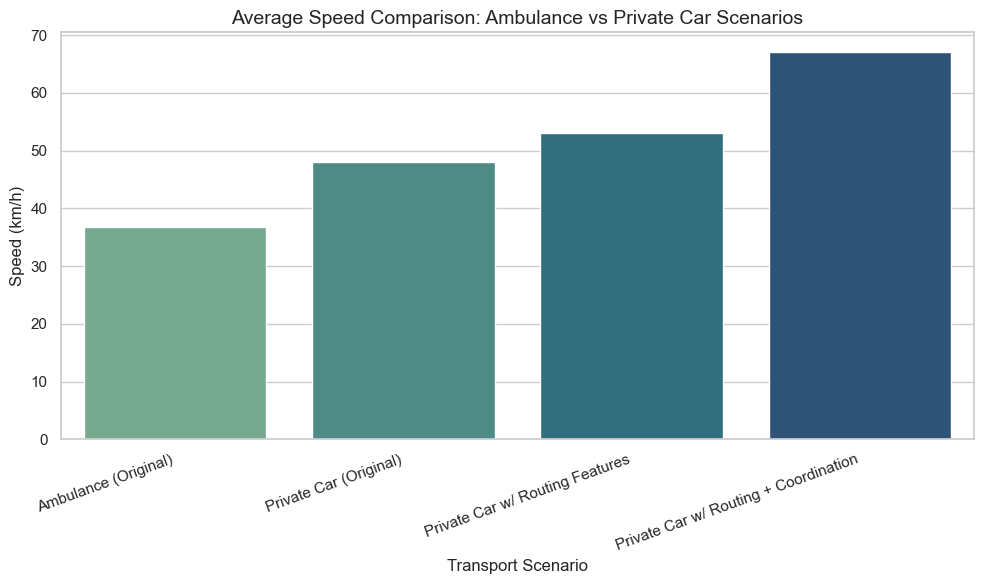

In [17]:
# style
sns.set(style="whitegrid")

# Creating a plot
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_speeds, x="Scenario", y="Avg Speed (km/h)", palette="crest")

# Title and formatting
plt.title("Average Speed Comparison: Ambulance vs Private Car Scenarios", fontsize=14)
plt.ylabel("Speed (km/h)")
plt.xlabel("Transport Scenario")
plt.xticks(rotation=20, ha='right')
plt.tight_layout()
plt.show()


Based on the output we got to know the average amulance is 36.85km/hr. Above this we had a private car speed clocking at 48.07 km/hr. With ease of manovering privatevehical by saving just 4 mins of FMCTD the average speed of private car got increased to 53.06km/hr. Later by adding another 4 mins after introducing ease of patient handover in hospital the speed further got increased to 67.14 km/hr.


In [18]:
# Using the average speed from the previous summary
avg_speed_ambulance = avg_speeds.loc[avg_speeds["Scenario"] == "Ambulance (Original)", "Avg Speed (km/h)"].values[0]
avg_speed_car = avg_speeds.loc[avg_speeds["Scenario"] == "Private Car (Original)", "Avg Speed (km/h)"].values[0]
avg_speed_car_optimized = avg_speeds.loc[avg_speeds["Scenario"] == "Private Car w/ Routing + Coordination", "Avg Speed (km/h)"].values[0]

# Copying the dataset
df_compare = df.copy()

# Estimate FMCTD based on average speed
df_compare["fmctd_estimated_speed"] = np.nan
df_compare.loc[df_compare["mode_of_arrival"] == "ambulance", "fmctd_estimated_speed"] = (
    df_compare["distance_km"] / avg_speed_ambulance * 60
)
df_compare.loc[df_compare["mode_of_arrival"] == "private_vehicle", "fmctd_estimated_speed"] = (
    df_compare["distance_km"] / avg_speed_car * 60
)

# Estimated FMCTD for optimized car scenario
df_compare["fmctd_estimated_car_optimized"] = np.nan
df_compare.loc[df_compare["mode_of_arrival"] == "private_vehicle", "fmctd_estimated_car_optimized"] = (
    df_compare["distance_km"] / avg_speed_car_optimized * 60
)

# Compute average FMCTD values for comparison
comparison_summary = pd.DataFrame({
    "Scenario": [
        "Actual FMCTD - Ambulance",
        "Actual FMCTD - Car",
        "Estimated FMCTD - Car (from Avg Speed)",
        "Estimated FMCTD - Car (Optimized Routing + Coordination)"
    ],
    "Avg FMCTD (mins)": [
        round(df_compare[df_compare["mode_of_arrival"] == "ambulance"]["fmctd_time_mins"].mean(), 2),
        round(df_compare[df_compare["mode_of_arrival"] == "private_vehicle"]["fmctd_time_mins"].mean(), 2),
        round(df_compare[df_compare["mode_of_arrival"] == "private_vehicle"]["fmctd_estimated_speed"].mean(), 2),
        round(df_compare[df_compare["mode_of_arrival"] == "private_vehicle"]["fmctd_estimated_car_optimized"].mean(), 2)
    ]
})

comparison_summary.head()

,Scenario,Avg FMCTD (mins)
0,Actual FMCTD - Ambulance,57.65
1,Actual FMCTD - Car,44.85
2,Estimated FMCTD - Car (from Avg Speed),43.67
3,Estimated FMCTD - Car (Optimized Routing + Coo...,31.27


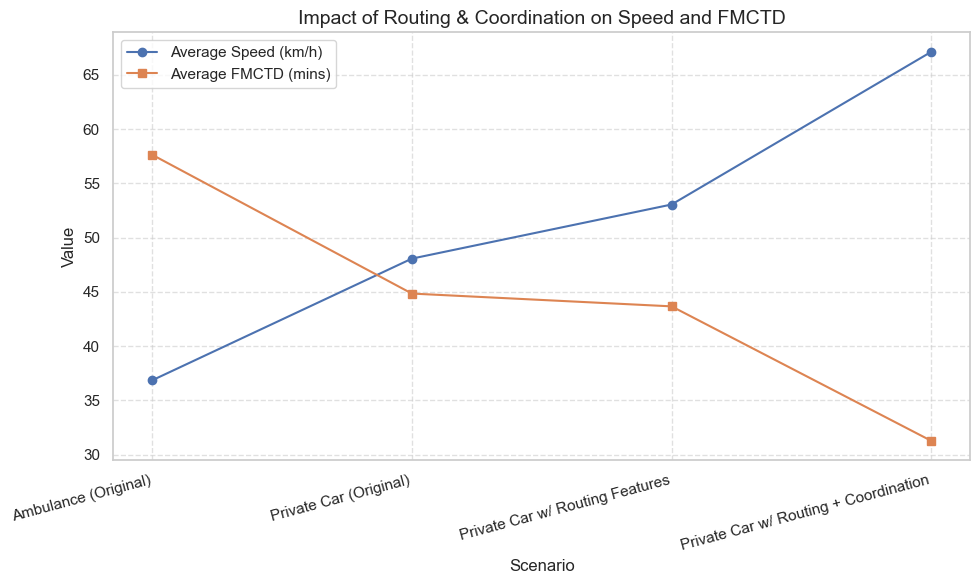

In [19]:
import matplotlib.pyplot as plt

# Extracting speeds 
speed_vals = avg_speeds["Avg Speed (km/h)"].values
speed_labels = avg_speeds["Scenario"].values

# Extracting FMCTD
fmctd_labels = [
    "Actual FMCTD - Ambulance",
    "Actual FMCTD - Car",
    "Estimated FMCTD - Car (from Avg Speed)",
    "Estimated FMCTD - Car (Optimized Routing + Coordination)"
]
fmctd_vals = comparison_summary.set_index("Scenario").loc[fmctd_labels]["Avg FMCTD (mins)"].values

# Plotting both on the same chart
plt.figure(figsize=(10,6))

plt.plot(speed_labels, speed_vals, marker="o", label="Average Speed (km/h)")
plt.plot(speed_labels, fmctd_vals, marker="s", label="Average FMCTD (mins)")

# Labels and formatting
plt.title("Impact of Routing & Coordination on Speed and FMCTD", fontsize=14)
plt.xlabel("Scenario", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(rotation=15, ha="right")
plt.tight_layout()
plt.show()


Based on above checks we have a new average FMCTD of ambulance as 55.34 which got reduced by 2 second as we have used the speed of ambulance calibarated using FMCTD and distance data present in the dataset. Similarly for car the new FMCTD got reduced by 1 sec once we have used the average speed calculated from the variables in the dataset. By using new optimised speed of car using the fratures introducted to car we have further reduced the FMCTD for patient to 35.43 mins

# Case 4: ECG Time

/var/folders/3g/sf0njf911zxb8wq5ht4vd1g80000gn/T/ipykernel_39520/3568777741.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=summary_ecg_stages, x="Scenario", y="Avg ECG Time (mins)", palette="Set2")
/Users/krishnasingh/.local/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/krishnasingh/.local/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group

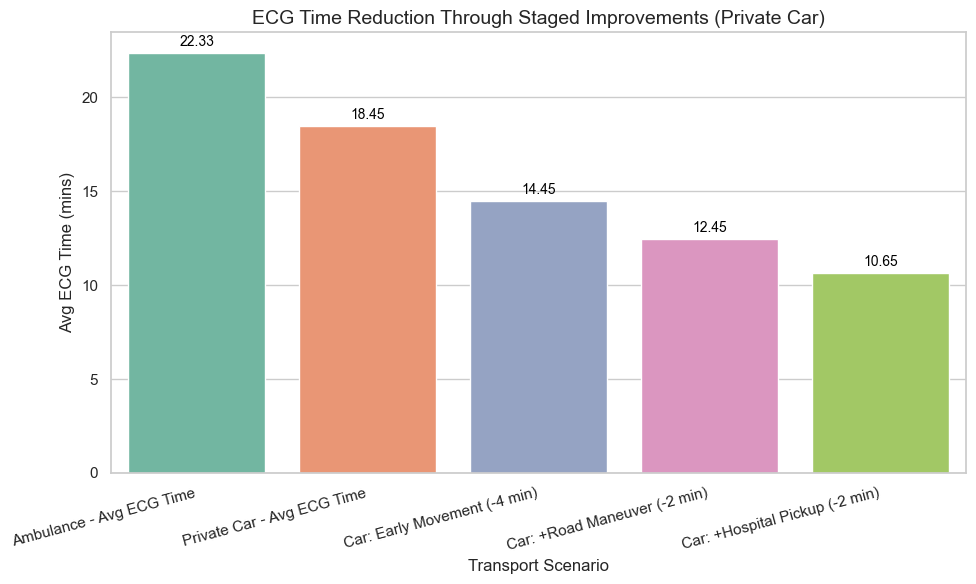

In [20]:

# Creating a copy
df_ecg = df.copy()

# Calculating the average ECG time by mode of arrival
ecg_by_mode = df_ecg.groupby("mode_of_arrival")["ecg_time_mins"].mean().reset_index()
ecg_by_mode.columns = ["Mode of Arrival", "Avg ECG Time (mins)"]

# Adding distance category 1 and 2 based on distance less or more than 15 KM
df_ecg["distance_category"] = np.where(df_ecg["distance_km"] <= 15, "Category_1", "Category_2")

# Applying staged improvements for private vehicle patients
# Base ECG time for car
df_ecg["ecg_car_normal"] = df_ecg["ecg_time_mins"]

# 1st improvement where we have 4 mins early movement, and we try to skip the call centre for ambulance
df_ecg["ecg_car_stage1"] = df_ecg["ecg_car_normal"]
df_ecg.loc[df_ecg["mode_of_arrival"] == "private_vehicle", "ecg_car_stage1"] -= 4

# 2nd improvement where we have certain automations in the car that help us in gaining +5 mins for road manoeuvring
df_ecg["ecg_car_stage2"] = df_ecg["ecg_car_stage1"]
df_ecg.loc[df_ecg["mode_of_arrival"] == "private_vehicle", "ecg_car_stage2"] -= 2

# 3rd improvement is when we have a good emergency team that helps us gain +5 mins for hospital-side emergency pickup
df_ecg["ecg_car_stage3"] = df_ecg["ecg_car_stage2"]
df_ecg.loc[df_ecg["mode_of_arrival"] == "private_vehicle", "ecg_car_stage3"] -= 2

# Clip all ECG values to a minimum 0
for col in ["ecg_car_stage1", "ecg_car_stage2", "ecg_car_stage3"]:
    df_ecg[col] = df_ecg[col].clip(lower=0)

# Create a summary 
summary_ecg_stages = pd.DataFrame({
    "Scenario": [
        "Ambulance - Avg ECG Time",
        "Private Car - Avg ECG Time",
        "Car: Early Movement (-4 min)",
        "Car: +Road Maneuver (-2 min)",
        "Car: +Hospital Pickup (-2 min)"
    ],
    "Avg ECG Time (mins)": [
        round(df_ecg[df_ecg["mode_of_arrival"] == "ambulance"]["ecg_time_mins"].mean(), 2),
        round(df_ecg[df_ecg["mode_of_arrival"] == "private_vehicle"]["ecg_car_normal"].mean(), 2),
        round(df_ecg[df_ecg["mode_of_arrival"] == "private_vehicle"]["ecg_car_stage1"].mean(), 2),
        round(df_ecg[df_ecg["mode_of_arrival"] == "private_vehicle"]["ecg_car_stage2"].mean(), 2),
        round(df_ecg[df_ecg["mode_of_arrival"] == "private_vehicle"]["ecg_car_stage3"].mean(), 2)
    ]
})

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=summary_ecg_stages, x="Scenario", y="Avg ECG Time (mins)", palette="Set2")
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',   # format with 2 decimals
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 3),
                textcoords='offset points')

plt.title("ECG Time Reduction Through Staged Improvements (Private Car)", fontsize=14)
plt.ylabel("Avg ECG Time (mins)")
plt.xlabel("Transport Scenario")
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()



In [21]:
summary_ecg_stages

,Scenario,Avg ECG Time (mins)
0,Ambulance - Avg ECG Time,22.33
1,Private Car - Avg ECG Time,18.45
2,Car: Early Movement (-4 min),14.45
3,Car: +Road Maneuver (-2 min),12.45
4,Car: +Hospital Pickup (-2 min),10.65


# Case 5: Finding correct location based on population density to open a new PCI centers

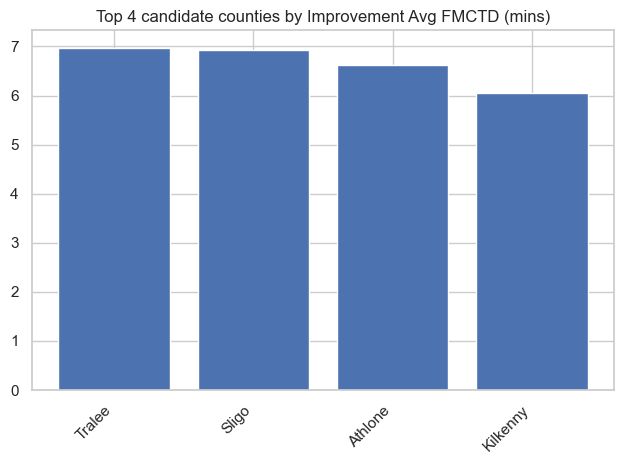

,County,New site lat,New site lon,Patients (county),Far patients (county),Far rate (county),Reassigned (total),Reassigned (in county),Avg FMCTD baseline (mins),Avg FMCTD new (mins),Improvement Avg FMCTD (mins),% PCI ≤90 baseline,% PCI ≤90 new,Improvement PCI ≤90 (pp)
0,Tralee,52.272232,-9.705307,1042,1042,1.0,1042,1042,73.7192,66.740378,6.978822,72.197068,75.075464,2.878396
1,Sligo,54.277315,-8.478679,1032,1032,1.0,1032,1032,73.7192,66.784562,6.934638,72.197068,75.107805,2.910737
2,Athlone,53.425286,-7.946791,982,982,1.0,1135,982,73.7192,67.094979,6.624221,72.197068,75.053903,2.856835
3,Kilkenny,52.654486,-7.246228,976,976,1.0,989,976,73.7192,67.673080,6.046120,72.197068,74.946097,2.749030


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Haversine formula
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

def _prep(df_in):
    needed = ["patient_lat","patient_lon","hospital_lat","hospital_lon","distance_km","fmctd_time_mins","county"]
    missing = [c for c in needed if c not in df_in.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")
    d = df_in.copy()
    for c in ["patient_lat","patient_lon","hospital_lat","hospital_lon","distance_km","fmctd_time_mins"]:
        d[c] = pd.to_numeric(d[c], errors="coerce")
    d = d.dropna(subset=["patient_lat","patient_lon","hospital_lat","hospital_lon","distance_km","fmctd_time_mins"])
    if "reperfusion_type" not in d.columns:
        d["reperfusion_type"] = ""
    d["is_pci"] = d["reperfusion_type"].astype(str).str.lower().str.contains("pci", na=False)
    return d

def evaluate_new_pci_for_county(df_in, county, dist_threshold_km=60.0, catchment="all"):

    d = df_in.copy()
    # define 'is far' with threshold
    d["is_far"] = d["distance_km"] > dist_threshold_km
    far_c = d[(d["county"] == county) & (d["is_far"])].copy()
    if far_c.empty:
        # top 25% far inside county
        cut = d.loc[d["county"] == county, "distance_km"].quantile(0.75)
        far_c = d[(d["county"] == county) & (d["distance_km"] >= cut)].copy()
        if far_c.empty:
            return None

    # new PCI at the centroid of far patients in Ireland
    new_lat = float(far_c["patient_lat"].mean())
    new_lon = float(far_c["patient_lon"].mean())

    # distances to the new PCI
    if catchment == "county":
        mask_catch = d["county"] == county
    else:
        mask_catch = np.ones(len(d), dtype=bool)

    d = d.copy()
    d["dist_new_km"] = np.nan
    d.loc[mask_catch, "dist_new_km"] = haversine_km(
        d.loc[mask_catch, "patient_lat"],
        d.loc[mask_catch, "patient_lon"],
        new_lat, new_lon
    )

    # assign all close to new PCI
    assigned = mask_catch & (d["dist_new_km"] < d["distance_km"])
    d["assigned_hospital"] = np.where(assigned, "new_pci", "existing")
    d["new_distance_km"] = np.where(assigned, d["dist_new_km"], d["distance_km"])

    # recomputing FMCTD, distance
    scale = np.where(d["distance_km"] > 0, d["new_distance_km"] / d["distance_km"], 1.0)
    d["fmctd_time_mins_new"] = (d["fmctd_time_mins"] * scale).clip(lower=0)

    # metrics
    base_mean = d["fmctd_time_mins"].mean()
    new_mean  = d["fmctd_time_mins_new"].mean()
    base_pci90 = 100 * d.loc[d["is_pci"], "fmctd_time_mins"].le(90).mean() if d["is_pci"].any() else np.nan
    new_pci90  = 100 * d.loc[d["is_pci"], "fmctd_time_mins_new"].le(90).mean() if d["is_pci"].any() else np.nan

    # county-level context
    total_cnty = int((d["county"] == county).sum())
    far_cnty = int(((d["county"] == county) & (d["is_far"])).sum())
    far_rate = (far_cnty / total_cnty) if total_cnty > 0 else np.nan
    reassigned_total = int(assigned.sum())
    reassigned_in_cnty = int((assigned & (d["county"] == county)).sum())

    return {
        "County": county,
        "New site lat": new_lat,
        "New site lon": new_lon,
        "Patients (county)": total_cnty,
        "Far patients (county)": far_cnty,
        "Far rate (county)": far_rate,
        "Reassigned (total)": reassigned_total,
        "Reassigned (in county)": reassigned_in_cnty,
        "Avg FMCTD baseline (mins)": float(base_mean),
        "Avg FMCTD new (mins)": float(new_mean),
        # positive = improvement (mins reduced)
        "Improvement Avg FMCTD (mins)": float(base_mean - new_mean),
        "% PCI ≤90 baseline": float(base_pci90),
        "% PCI ≤90 new": float(new_pci90),
        # positive = improvement in percentage points
        "Improvement PCI ≤90 (pp)": float(new_pci90 - base_pci90)
    }

def rank_pci_locations(df_in,
                       dist_threshold_km=60.0,
                       min_far=50,
                       min_total=200,
                       rate_threshold=0.3,   
                       catchment="all",
                       rank_by="Improvement Avg FMCTD (mins)",
                       top_k=10,
                       show_plot=True):
   
    d = _prep(df_in)

    # define far using threshold 
    d["is_far"] = d["distance_km"] > dist_threshold_km
    if not d["is_far"].any():
        cut = d["distance_km"].quantile(0.75)
        d["is_far"] = d["distance_km"] >= cut

    # candidate counties based on filters
    g = d.groupby("county").agg(
        total=("patient_id","size"),
        far_count=("is_far","sum"),
        far_rate=("is_far","mean"),
        mean_dist=("distance_km","mean")
    )
    cand = g[
        (g["total"] >= min_total) &
        (g["far_count"] >= min_far) &
        ((g["far_rate"] >= (rate_threshold if rate_threshold is not None else 0.0)))
    ].copy()

    if cand.empty:
        raise ValueError("No counties met the candidate filters. Try lowering min_far/min_total or rate_threshold.")

    # evaluating each candidate county
    rows = []
    for county in cand.index:
        res = evaluate_new_pci_for_county(d, county,
                                          dist_threshold_km=dist_threshold_km,
                                          catchment=catchment)
        if res is not None:
            rows.append(res)

    if not rows:
        raise ValueError("Evaluation produced no results — check your filters.")

    sites = pd.DataFrame(rows)

    # rank
    ascending = False if rank_by in ["Improvement Avg FMCTD (mins)", "Improvement PCI ≤90 (pp)"] else True
    sites = sites.sort_values(rank_by, ascending=ascending).reset_index(drop=True)

    # optional plot 
    if show_plot:
        k = min(top_k, len(sites))
        plt.figure()
        plt.bar(sites["County"].head(k), sites[rank_by].head(k))
        plt.xticks(rotation=45, ha="right")
        plt.title(f"Top {k} candidate counties by {rank_by}")
        plt.tight_layout()
        plt.show()

    return sites


all_candidates = rank_pci_locations(
    df,
    dist_threshold_km=20.0,  # change if you like
    min_far=50,              # require at least 50 far patients in a county
    min_total=200,           # and at least 200 patients total
    rate_threshold=0.1,     # require >=10% far (set None to disable)
    catchment="all",         # or "county"
    rank_by="Improvement Avg FMCTD (mins)",
    top_k=10,
    show_plot=True
)



all_candidates.head(20)


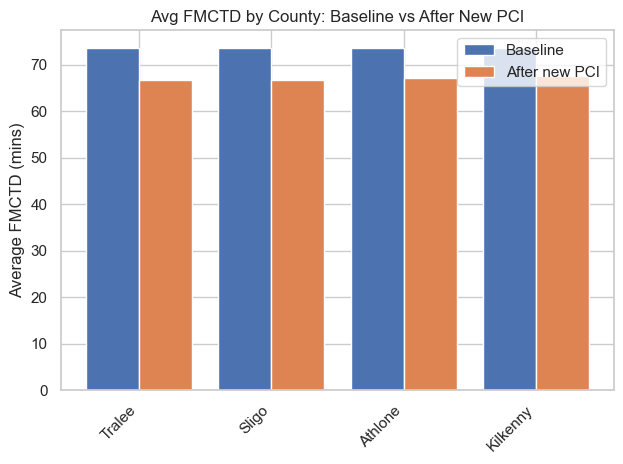

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def plot_before_after_fmctd_by_county(sites: pd.DataFrame, top_k: int = 10, title_suffix: str = ""):
   
    k = min(top_k, len(sites))
    subset = sites.head(k)

    x = np.arange(k)
    width = 0.4

    plt.figure()
    plt.bar(x - width/2, subset["Avg FMCTD baseline (mins)"].values, width, label="Baseline")
    plt.bar(x + width/2, subset["Avg FMCTD new (mins)"].values, width, label="After new PCI")
    plt.xticks(x, subset["County"].tolist(), rotation=45, ha="right")
    plt.ylabel("Average FMCTD (mins)")
    plt.title(f"Avg FMCTD by County: Baseline vs After New PCI{title_suffix}")
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_before_after_fmctd_by_county(all_candidates, top_k=10)


In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_pci_candidate_sites(
    sites: pd.DataFrame,
    metric: str = "Improvement Avg FMCTD (mins)",
    top_k: int | None = 20,
    annotate: bool = True,
    overlay_existing: bool = True,
    df_all: pd.DataFrame | None = None,   # pass your original df if you want hospitals overlaid
    title_suffix: str = ""
):
    
    # Required columns
    req = {"County", "New site lat", "New site lon", metric}
    missing = req - set(sites.columns)
    if missing:
        raise ValueError(f"sites is missing columns: {missing}")

    plot_df = sites.copy()
    if top_k is not None:
        plot_df = plot_df.head(top_k)

    # Bubble sizes 
    vals = plot_df[metric].values.astype(float)
    vmin, vmax = float(np.min(vals)), float(np.max(vals))
    rng = max(vmax - vmin, 1e-9)
    sizes = 120 + 1000 * (vals - vmin) / rng  # 120–1120

    plt.figure()
    # overlay existing hospitals 
    if overlay_existing and df_all is not None and {"hospital_lat","hospital_lon"}.issubset(df_all.columns):
        hosp = (
            df_all[["hospital_lat","hospital_lon"]]
            .dropna()
            .drop_duplicates()
        )
        plt.scatter(hosp["hospital_lon"], hosp["hospital_lat"], marker="^", s=30, label="Existing hospitals")

    # New PCI candidate sites
    plt.scatter(plot_df["New site lon"], plot_df["New site lat"], s=sizes, marker="*", label="New PCI candidates")

    if annotate:
        for _, r in plot_df.iterrows():
            plt.annotate(r["County"], (r["New site lon"], r["New site lat"]), xytext=(3,3), textcoords="offset points")

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"Proposed New PCI Centers (bubble size ∝ {metric}){title_suffix}")
    plt.legend()
    plt.tight_layout()
    plt.show()


/var/folders/3g/sf0njf911zxb8wq5ht4vd1g80000gn/T/ipykernel_39520/2689671951.py:52: UserWarning: Glyph 8733 (\N{PROPORTIONAL TO}) missing from current font.
  plt.tight_layout()
/Users/krishnasingh/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8733 (\N{PROPORTIONAL TO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


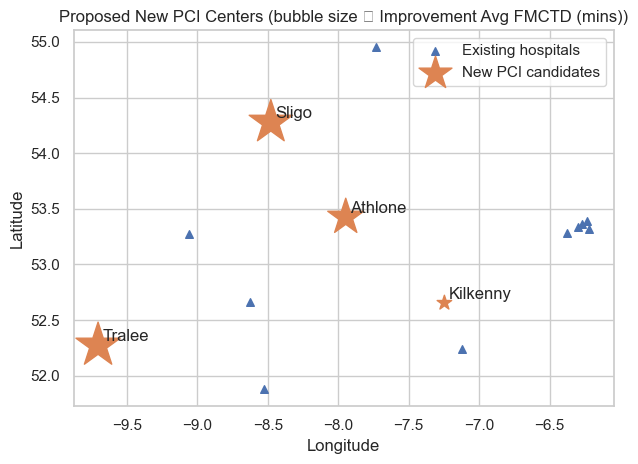

In [33]:
# PCI Locations new
plot_pci_candidate_sites(
    all_candidates,
    metric="Improvement Avg FMCTD (mins)",  
    top_k=20,
    annotate=True,
    overlay_existing=True,
    df_all=df
)
